In [1]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# yfinance is used to fetch data
import yfinance as yf

import warnings
warnings.simplefilter("ignore")

[*********************100%***********************]  1 of 1 completed


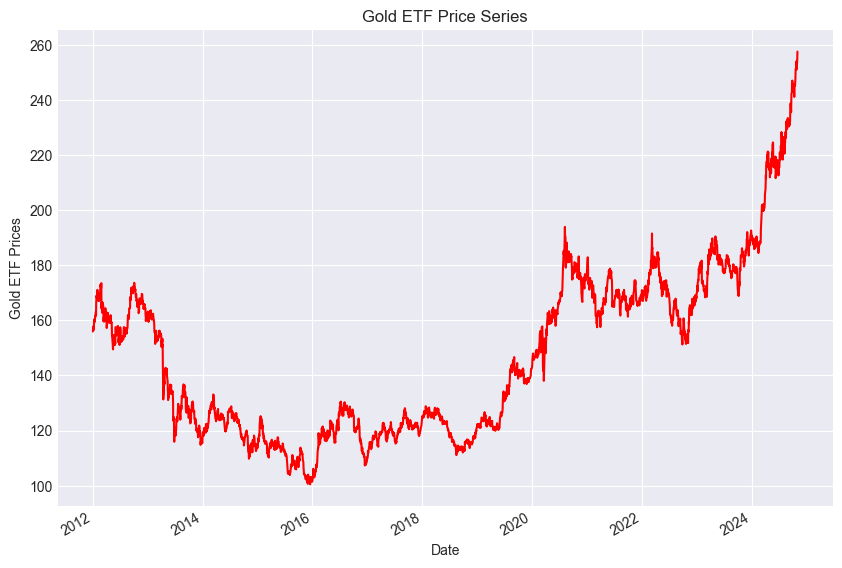

In [2]:
# Read data
Df = yf.download('GLD', '2012-01-01', '2024-10-31', auto_adjust=True)

# Only keep close columns
Df = Df[['Close']]

# Drop rows with missing values
Df = Df.dropna()

# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

In [3]:
# Define explanatory variables
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S_3', 'S_9']]

# Define dependent variable
y = Df['next_day_price']

In [4]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold ETF Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
Gold ETF Price (y) = 1.17 * 3 Days Moving Average (x1) + -0.17 * 9 Days Moving Average (x2) + 0.28 (constant)


In [5]:
S_3 = Df['S_3'].dropna()
S_9 = Df['S_9'].dropna()

# Since S_3 and S_9 are moving averages, we could check their cointegration with the original Close series
close_price = Df['next_day_price']

# Conduct Engle-Granger Cointegration Test between S_3 and Close price
coint_result_3 = coint(S_3, close_price)

# Conduct Engle-Granger Cointegration Test between S_9 and Close price
coint_result_9 = coint(S_9, close_price)

# Extract p-values
p_value_3 = coint_result_3[1]
p_value_9 = coint_result_9[1]

# Print the results
print(f"Cointegration p-value between S_3 and next_day_price: {p_value_3}")
print(f"Cointegration p-value between S_9 and next_day_price: {p_value_9}")

# Interpretation
alpha = 0.05
if p_value_3 < alpha:
    print("S_3 and next_day_price are cointegrated.")
else:
    print("S_3 and next_day_price are not cointegrated.")

if p_value_9 < alpha:
    print("S_9 and next_day_price are cointegrated.")
else:
    print("S_9 and next_day_price are not cointegrated.")

Cointegration p-value between S_3 and next_day_price: 0.0
Cointegration p-value between S_9 and next_day_price: 5.54437936472372e-26
S_3 and next_day_price are cointegrated.
S_9 and next_day_price are cointegrated.


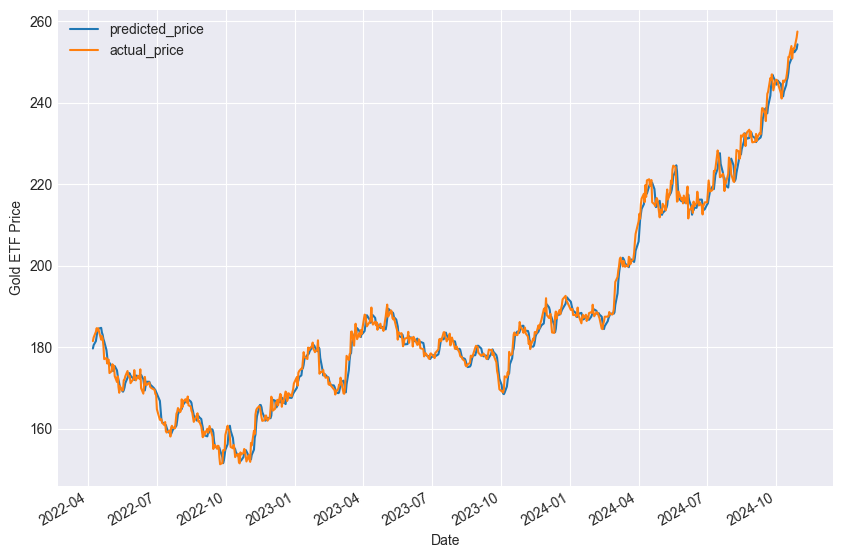

99.32

In [6]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

In [7]:
gold = pd.DataFrame()

gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

In [8]:
gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)
gold.head()

,price,predicted_price_next_day,actual_price_next_day,gold_returns,signal
Date,,,,,
2022-04-07,180.339996,179.658889,181.470001,0.006266,0
2022-04-08,181.470001,180.483356,182.369995,0.004959,1
2022-04-11,182.369995,181.479473,183.770004,0.007677,1
2022-04-12,183.770004,182.757575,184.649994,0.004789,1
2022-04-13,184.649994,183.922404,184.039993,-0.003304,1


In [9]:
gold['actual_price_next_day'] = gold.price.shift(-1)
gold['actual_signal'] = np.where(gold.actual_price_next_day.shift(1) < gold.actual_price_next_day,1,0)
gold.tail()

,price,predicted_price_next_day,actual_price_next_day,gold_returns,signal,actual_signal
Date,,,,,,
2024-10-23,250.869995,252.345583,252.800003,0.007693,0,1
2024-10-24,252.800003,252.821267,253.320007,0.002057,1,1
2024-10-25,253.320007,252.423868,253.330002,0.000039,0,1
2024-10-28,253.330002,253.241709,256.089996,0.010895,1,1
2024-10-29,256.089996,254.354197,NaN,NaN,1,0


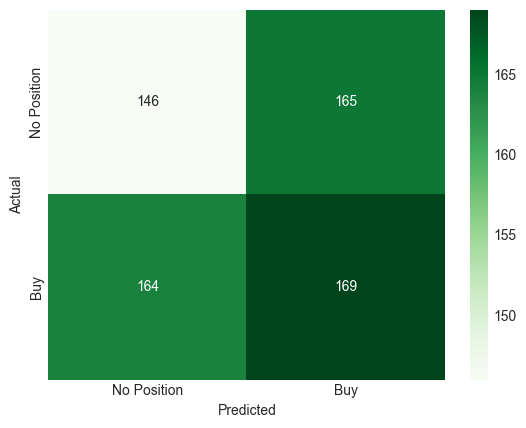

In [10]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(gold['actual_signal'], gold['signal'])
df = pd.DataFrame(array, index = ['No Position','Buy'], columns = ['No Position','Buy'])

# Plot the heatmap
import seaborn as sns
sns.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

As you can see that, 169 days the prediction of Buy was successful but 165 days prediction of Buy was not. This caused the loss in the strategy.

In [11]:
from sklearn.metrics import classification_report
print(classification_report(gold['actual_signal'], gold['signal'], target_names=['No Position','Buy']))

              precision    recall  f1-score   support

 No Position       0.47      0.47      0.47       311
         Buy       0.51      0.51      0.51       333

    accuracy                           0.49       644
   macro avg       0.49      0.49      0.49       644
weighted avg       0.49      0.49      0.49       644



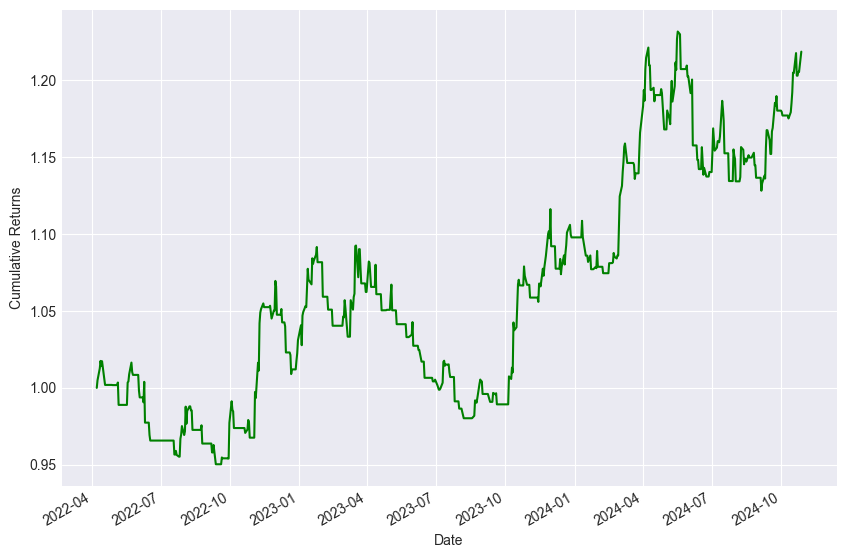

In [12]:
gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

In [13]:
'Sharpe Ratio %.2f' % (gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5))

'Sharpe Ratio 0.76'

# How to use this model to predict daily moves?

In [14]:
import datetime as dt
current_date = dt.datetime.now()
data = yf.download('GLD', '2008-06-01', current_date, auto_adjust=True)
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()
data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")
data.tail(1)[['signal','predicted_gold_price']].T

[*********************100%***********************]  1 of 1 completed


Date,2024-11-18
signal,Buy
predicted_gold_price,237.394006
